In [459]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])
from scipy.optimize import curve_fit, minimize
import pydicom
import pandas as pd
import cv2
from scipy.ndimage import convolve
from matplotlib import colors
import pymedphys

# Open Data

In [2]:
dpi=72

In [3]:
cali_curves = np.loadtxt('Lab2Data/Cal_RGB.csv', skiprows = 5, delimiter=',', usecols=np.arange(6))
cali_dose, cali_r, _, cali_g, _, cali_b = cali_curves.T

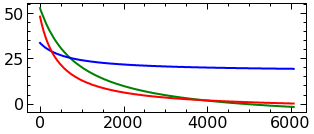

In [4]:
plt.figure(figsize=(5,2))
plt.plot(cali_dose, cali_g, color='g')
plt.plot(cali_dose, cali_b, color='b')
plt.plot(cali_dose, cali_r, color='r')
plt.show()

In [5]:
TPdose1mm = pydicom.read_file('Lab2Data/TPdose_calc_1mm_res.dcm')
TPdose2mm = pydicom.read_file('Lab2Data/TPdose_calc_2mm_res.dcm')
f1mm = float(TPdose1mm.DoseGridScaling)
f2mm = float(TPdose2mm.DoseGridScaling)

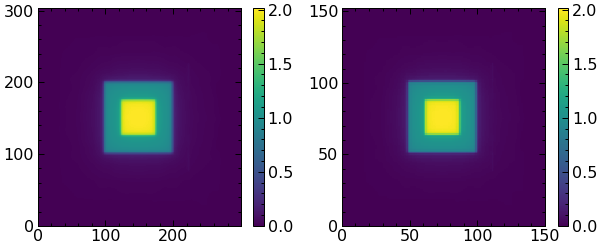

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
CS1 = ax[0].pcolor(TPdose1mm.pixel_array * f1mm)
CS2 = ax[1].pcolor(TPdose2mm.pixel_array * f2mm)
plt.colorbar(CS1, ax=ax[0])
plt.colorbar(CS2, ax=ax[1])
plt.show()

In [7]:
pred_dose = TPdose1mm.pixel_array * f1mm

# Other Stuf

In [8]:
def open_array(arr_type, color): 
    arr = np.loadtxt(f'Lab2Data/Image{arr_type}Values_{color}.csv', skiprows = 8, delimiter=',',
                         dtype=str)
    arr = arr[:,0:-1].astype(float)
    return arr

In [9]:
green_dose = open_array('Dose', 'green')
blue_dose = open_array('Dose', 'blue')
red_dose = open_array('Dose', 'red')
green_channel = open_array('Channel', 'green')
blue_channel = open_array('Channel', 'blue')
red_channel = open_array('Channel', 'red')

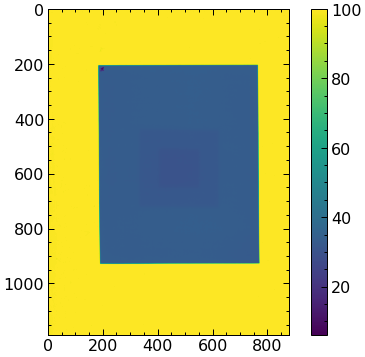

In [10]:
plt.imshow(blue_channel)
plt.colorbar()

# Calibration

Data

In [11]:
dose = np.array([0,50,100,150,200,250,300]) / 100
red = np.array([48,43,39.2,35.8,32.6,30.1,28]) / 100
blue = np.array([33.3,32.4,31.8,30.9,29.9,29.2,28.5]) / 100
green = np.array([52.7,49.5,46.9,44.2,41.6,39.4,37.4]) / 100

Define curve

In [12]:
def curve(D,A,B,C):
    return A+B/(D+C)

Optimal parameters

In [13]:
popt_g, pcov_g = curve_fit(curve, dose, green)
popt_r, pcov_r = curve_fit(curve, dose, red)
popt_b, pcov_b = curve_fit(curve, dose, blue, p0=[0,150,100])

In [14]:
D = np.linspace(0, 3, 100)

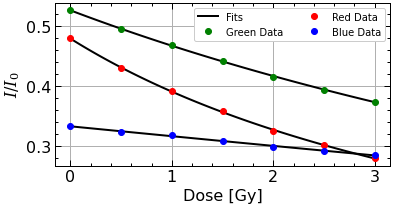

In [15]:
plt.figure(figsize=(6,3))
plt.plot(D, curve(D, *popt_g), ls='-', color='k', label='Fits')
plt.plot(dose,green, 'o', color='g', label='Green Data')
plt.plot(D, curve(D, *popt_r), ls='-', color='k')
plt.plot(dose,red, 'o', color='r', label='Red Data')
plt.plot(D, curve(D, *popt_b), ls='-', color='k')
plt.plot(dose,blue, 'o', color='b', label='Blue Data')
plt.grid()
plt.xlabel('Dose [Gy]')
plt.ylabel('$I/I_0$')
plt.legend(fontsize=10, ncol=2, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.savefig('Lab2Plots/Calibration.png', dpi=200)
plt.show()

Use to get 2D dose profiles:

In [16]:
def dose_f(I, A, B, C):
    return B/(I/100-A) - C

In [17]:
green_dose_pred = dose_f(green_channel, *popt_g)[300:850,250:700]
blue_dose_pred = dose_f(blue_channel, *popt_b)[300:850,250:700]
red_dose_pred = dose_f(red_channel, *popt_r)[300:850,250:700]

In [18]:
x = np.arange(0, green_dose_pred.shape[1], 1) *25.4/dpi
y = np.arange(0, green_dose_pred.shape[0], 1) *25.4/dpi
xv, yv = np.meshgrid(x,y)

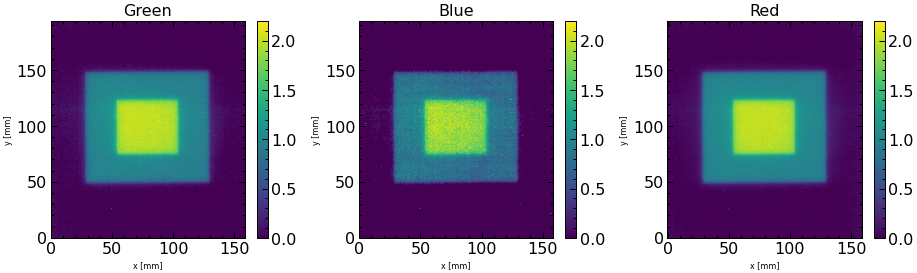

In [19]:
fig, ax = plt.subplots(1,3,figsize=(13,4))
CS1 = ax[0].pcolor(xv, yv, green_dose_pred, vmin=0, vmax=2.2)
CS2 = ax[1].pcolor(xv, yv, blue_dose_pred, vmin=0, vmax=2.2)
CS3 = ax[2].pcolor(xv, yv, red_dose_pred, vmin=0, vmax=2.2)
plt.colorbar(CS1, ax=ax[0])
plt.colorbar(CS2, ax=ax[1])
plt.colorbar(CS3, ax=ax[2])
ax[0].set_title('Green')
ax[1].set_title('Blue')
ax[2].set_title('Red')
[a.set_xlabel('x [mm]', fontsize=8) for a in ax]
[a.set_ylabel('y [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('Lab2Plots/each_color_profile.png', dpi=200)
plt.show()

# Dose Volume Histogram Comparison

Function to get dVH:

In [20]:
def get_DVH(arr, voxel_size, cumu=True):
    doses = arr.ravel()
    V, D = np.histogram(doses, bins=100, weights=np.ones(len(doses))*voxel_size)
    if cumu:
        return D[1:] - np.diff(D)[0]/2, np.cumsum(V[::-1])[::-1]
    else:
        return D[1:] - np.diff(D)[0]/2, V

# Plotting

Dose volume histograms:

In [21]:
dpi = 72

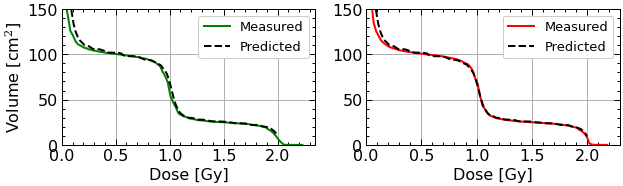

In [22]:
plt.subplots(1, 2, figsize=(10,2.5))
plt.subplot(121)
plt.plot(*get_DVH(green_dose_pred, 2.54**2 / dpi**2), label='Measured', color='g') #inches to cm plus 72 dpi
plt.plot(*get_DVH(pred_dose, 1/100), color='k', ls='--', label='Predicted') #voxel size in cm
plt.ylim(top=150)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Dose [Gy]')
plt.ylabel(r'Volume [cm$^2$]')
plt.grid()
plt.legend(fontsize=13, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.subplot(122)
plt.plot(*get_DVH(red_dose_pred, 2.54**2 / dpi**2), label='Measured', color='r') #inches to cm plus 72 dpi
plt.plot(*get_DVH(pred_dose, 1/100), color='k', ls='--', label='Predicted') #voxel size in cm
plt.ylim(top=150)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Dose [Gy]')
plt.grid()
plt.legend(fontsize=13, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.savefig('Lab2Plots/DVH_cumu.png', dpi=200)
plt.show()

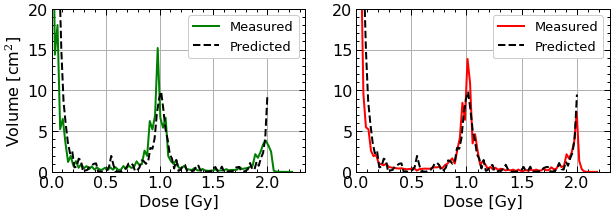

In [23]:
plt.subplots(1, 2, figsize=(10,3))
plt.subplot(121)
plt.plot(*get_DVH(green_dose_pred, 2.54**2 / dpi**2, cumu=False), label='Measured', color='g') #inches to cm plus 72 dpi
plt.plot(*get_DVH(pred_dose, 1/100, cumu=False), color='k', ls='--', label='Predicted') #voxel size in cm
plt.ylim(top=20)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Dose [Gy]')
plt.ylabel(r'Volume [cm$^2$]')
plt.grid()
plt.legend(fontsize=13, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.subplot(122)
plt.plot(*get_DVH(red_dose_pred, 2.54**2 / dpi**2, cumu=False), label='Measured', color='r') #inches to cm plus 72 dpi
plt.plot(*get_DVH(pred_dose, 1/100, cumu=False), color='k', ls='--', label='Predicted') #voxel size in cm
plt.ylim(top=20)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Dose [Gy]')
plt.grid()
plt.legend(fontsize=13, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.savefig('Lab2Plots/DVH_density.png', dpi=200)
plt.show()

# Gamma

## Aligning the Images

In [24]:
a1 = pred_dose[75:225,75:225]

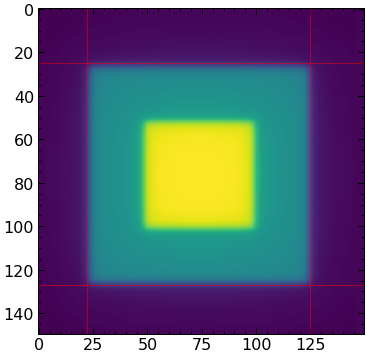

In [25]:
plt.imshow(a1)
plt.axvline(22, color='r', lw=0.5)
plt.axhline(25, color='r', lw=0.5)
plt.axhline(127, color='r', lw=0.5)
plt.axvline(125, color='r', lw=0.5)

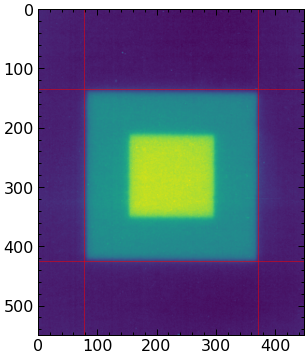

In [26]:
plt.imshow(green_dose_pred)
plt.axvline(78, color='r', lw=0.5)
plt.axvline(372, color='r', lw=0.5)
plt.axhline(135, color='r', lw=0.5)
plt.axhline(425, color='r', lw=0.5)

In [473]:
a1 = pred_dose[75:225,75:225]
a2 = green_dose_pred
src = np.float32([[22,25],[22,127],[125,25]])
dst = np.float32([[79,135],[79,425],[372,135]])

In [474]:
def transform_img(a1, a2, src, dst):
    M = cv2.getAffineTransform(src,dst)
    a1_new = cv2.warpAffine(a1, M, a2.shape[::-1])
    return a1_new
def MSE(X):
    src = X[0:6].reshape(3,2).astype(np.float32)
    dst = X[6:].reshape(3,2).astype(np.float32)
    trans = transform_img(a1,a2,src,dst)
    o_grad1, o_grad2 = np.gradient(a2)
    t_grad1, t_grad2 = np.gradient(trans)
    res = np.mean((o_grad1 - t_grad1)**2 + (o_grad2 - t_grad2)**2)
    return res

In [475]:
opt = minimize(MSE, np.concatenate([src.ravel(), dst.ravel()]), method='Powell',
              tol=1e-8).x
src_opt = opt[:6].reshape(3,2).astype(np.float32)
dst_opt = opt[6:].reshape(3,2).astype(np.float32)

In [476]:
experiment = a2
theory = transform_img(a1,a2,src_opt,dst_opt)
res = experiment - theory

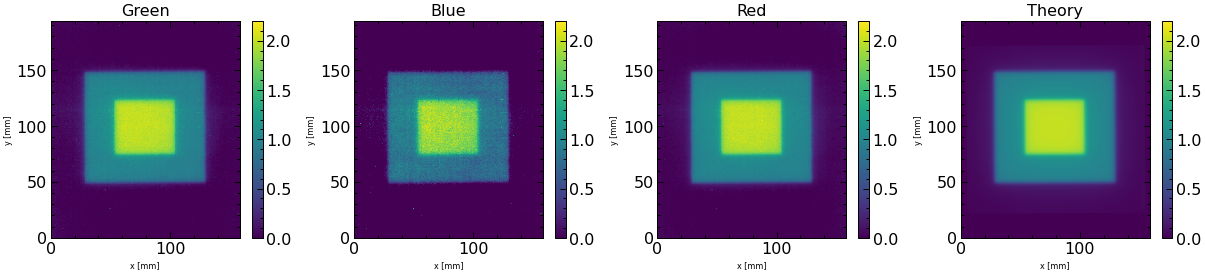

In [477]:
fig, ax = plt.subplots(1,4,figsize=(17,4))
CS1 = ax[0].pcolor(xv, yv, green_dose_pred, vmin=0, vmax=2.2)
CS2 = ax[1].pcolor(xv, yv, blue_dose_pred, vmin=0, vmax=2.2)
CS3 = ax[2].pcolor(xv, yv, red_dose_pred, vmin=0, vmax=2.2)
CS4 = ax[3].pcolor(xv, yv, theory, vmin=0, vmax=2.2)
plt.colorbar(CS1, ax=ax[0])
plt.colorbar(CS2, ax=ax[1])
plt.colorbar(CS3, ax=ax[2])
plt.colorbar(CS4, ax=ax[3])
ax[0].set_title('Green')
ax[1].set_title('Blue')
ax[2].set_title('Red')
ax[3].set_title('Theory')
[a.set_xlabel('x [mm]', fontsize=8) for a in ax]
[a.set_ylabel('y [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('Lab2Plots/each_color_profile.png', dpi=200)
plt.show()

Residuals now plotted at the end with gamma!!!

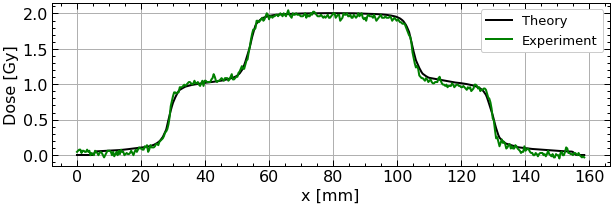

In [478]:
plt.figure(figsize=(10,3))
plt.plot(x,theory[250], label='Theory', color='k')
plt.plot(x,experiment[250], label='Experiment', color='g')
plt.xlabel('x [mm]')
plt.ylabel('Dose [Gy]')
plt.grid()
plt.legend(fontsize=13, facecolor='white', framealpha=1,
           frameon=True, loc='upper right')
plt.savefig('Lab2Plots/delta_dose_green_profile.png', dpi=200)

## Implmenting the Gamma

Trickz have been used

$$\Gamma(r_m, r_c) = \sqrt{\frac{|r_m-r_c|^2}{\Delta d_M^2} + \frac{|D(r_m)-D(r_c)|^2}{\Delta D_M^2}}$$

$$\gamma(r_m) = \text{min}_{r_c} \Gamma(r_m, r_c)$$

$r_m$ is one voxel, $r_c$ is all other voxels in the image

* $\Delta d_M$ and $\Delta D_M$ are prespecified distances and doses
* For a given $r_m$, rather than considering all $r_c$'s, only consider $r_c$s around the voxel (specified by `s` below).

In [479]:
gamma = pymedphys.gamma((y,x),theory,(y,x),experiment, dose_percent_threshold=2,
                        distance_mm_threshold=2)

Calcing using global normalisation point for gamma
Global normalisation set to 2.0098098613343747
Global dose threshold set to [0.0401962] ([2]% of normalisation)
Distance threshold set to [2]
Lower dose cutoff set to 0.40196197226687497 (20% of normalisation)

Current distance: 2.80 mm | Number of reference points remaining: 2 | Points tested per reference point: 89 | RAM split count: 1 111 | Points tested per reference point: 52 | RAM split count: 1 | Points tested per reference point: 64 | RAM split count: 1 | Points tested per reference point: 71 | RAM split count: 1 | Points tested per reference point: 83 | RAM split count: 1
Complete!


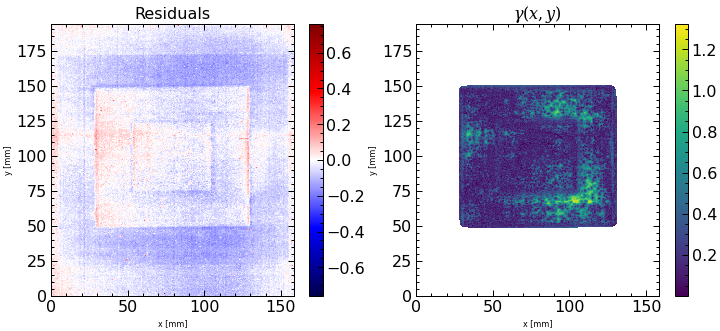

In [480]:
plt.subplots(1, 2, figsize=(12,5))
plt.subplot(122)
plt.pcolor(xv, yv, gamma, cmap='viridis')
plt.xlabel('x [mm]', fontsize=8)
plt.ylabel('y [mm]', fontsize=8)
plt.colorbar()
plt.title('$\gamma(x,y)$')
plt.subplot(121)
plt.title('Residuals')
plt.pcolor(xv, yv, res, cmap='seismic', norm=colors.CenteredNorm())
plt.colorbar()
plt.xlabel('x [mm]', fontsize=8)
plt.ylabel('y [mm]', fontsize=8)
fig.tight_layout()
plt.savefig('Lab2Plots/gamma_res_green.png', dpi=200)
plt.show()

# Trying to Implement the Gamma (Got Gibbs Ringing)

In [387]:
s = 3
kernels = [np.zeros((s,s)) for i in range(s**2)]
for i in range(s**2): 
    kernels[i].ravel()[i] = 1

**Above**: `s`$^2$ different kernels, each with an element of `1` in one location of an `s`x`s` matrix. We get an array $\Gamma(r_m, r_{c}^{(i)})$ for each one of these kernels

In [388]:
d = np.zeros((s,s))
for i in range(s):
    for j in range(s):
        d[i][j] = np.sqrt((i-s//2)**2 + (j-s//2)**2)
d = d.ravel()

**Above**: All the dose distances corresponding to each one of the $\Gamma(r_m, r_{c}^{(i)})$'s above.

In [389]:
pct_differences = np.array([(convolve(experiment, kernel, mode='constant')-theory)/(theory+1e-9) \
                            for kernel in kernels])

2%, 2mm passing rate criteria

In [390]:
dd = np.inf #mm
dd = dd / (25.4/dpi) #voxel units
dD = 0.02 # relative

In [420]:
gamma = np.min(np.sqrt((pct_differences/dD)**2 + (d.reshape(s**2,1,1)/dd)**2), axis=0)